In [1]:
import numpy as np
import tensorflow as tf

#the argument num_words=10000 keeps the top 10,000 most frequently occurring words in the training data. 
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.imdb.load_data(num_words=10000)

In [2]:
# Size of dataset
print(len(train_data))
print(len(train_labels))

25000
25000


## Explore the data

The dataset comes preprocessed: each example is an array of integers representing the words of the movie review. The text of reviews have been converted to integers, where each integer represents a specific word in a dictionary. 
Each label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

In [3]:
print(train_data[0])
print(train_labels[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1


Movie reviews may be different lengths. The below code shows the number of words in the first and second reviews. Since inputs to a neural network must be the same length, we'll need to resolve this later.

In [4]:
len(train_data[0]), len(train_data[1])

(218, 189)

### Decoding the integer sequences back into sequences

In [5]:
#word_index is a dictionary mapping words to an integer index
word_index = tf.keras.datasets.imdb.get_word_index()

# Our indices are offset by 3, 
#because 0,1 and 2 are reversed indices for "padding", "start of sequence", and "unknown".
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  
word_index["<UNUSED>"] = 3

#We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Decode the review
def decoded_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [6]:
decoded_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

### Prepare the Data

The reviews (the arrays of integers) must be converted to tensors before fed into the neural network. This conversion can be done a couple of ways:

* Convert the arrays into vectors of 0s and 1s indicating word occurrence, similar to a one-hot encoding. For example, the sequence [3, 5] would become a 10,000-dimensional vector that is all zeros except for indices 3 and 5, which are ones. Then, make this the first layer in our network—a Dense layer—that can handle floating point vector data. This approach is memory intensive, though, requiring a num_words * num_reviews size matrix.

* Alternatively, we can pad the arrays so they all have the same length, then create an integer tensor of shape max_length * num_reviews. We can use an embedding layer capable of handling this shape as the first layer in our network.

Here we shall use the second approach.

Since the movie reviews must be the same length, we will use the pad_sequences function to standardize the lengths:

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train = pad_sequences(train_data, value=word_index["<PAD>"],
                        padding='post',maxlen=256)

X_test = pad_sequences(test_data,value=word_index["<PAD>"],
                       padding='post', maxlen=256)

Let's look at the length of the examples now:

In [8]:
len(X_train[0]), len(X_test[1])

(256, 256)

And inspect the (now padded) first review:

In [9]:
print(X_train[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

### Model Training

The first layer is an Embedding layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding). Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.regularizers import l2

vocab_size = 10000

model = Sequential()
model.add(Embedding(vocab_size, 16))
model.add(GlobalAveragePooling1D())
model.add(Dense(64, activation=tf.nn.relu, kernel_regularizer=l2(1e-02)))
model.add(Dense(1, activation=tf.nn.sigmoid))
model.compile(optimizer ='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

W0830 14:32:57.433762 4805039552 deprecation.py:506] From /Users/zohebabai/anaconda/envs/TensorflowProjects/lib/python3.6/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0830 14:32:57.504918 4805039552 deprecation.py:506] From /Users/zohebabai/anaconda/envs/TensorflowProjects/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0830 14:32:57.672773 4805039552 deprecation.py:323] From /Users/zohebabai/anaconda/envs/TensorflowProjects/lib/python3.6/site-packages

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                1088      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 161,153
Trainable params: 161,153
Non-trainable params: 0
_________________________________________________________________


In [12]:
#Setting aside validation set
X_valid = X_train[:10000]
partial_X_train = X_train[10000:]

y_valid = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [13]:
# Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0, 
                               mode='auto', min_delta=1e-02, cooldown=0, min_lr=1e-08)

#Training the model

history = model.fit(partial_X_train, partial_y_train,
                   epochs =50, batch_size=512,
                   validation_data= (X_valid, y_valid),
                   callbacks=[lr_reducer])

Train on 15000 samples, validate on 10000 samples
Epoch 1/50
15000/15000 [==============================] - 5s 355us/sample - loss: 0.9261 - acc: 0.5120 - val_loss: 0.8865 - val_acc: 0.5452
Epoch 2/50
15000/15000 [==============================] - 4s 255us/sample - loss: 0.8567 - acc: 0.6533 - val_loss: 0.8270 - val_acc: 0.7023
Epoch 3/50
15000/15000 [==============================] - 4s 250us/sample - loss: 0.8043 - acc: 0.6977 - val_loss: 0.7824 - val_acc: 0.7346
Epoch 4/50
15000/15000 [==============================] - 4s 253us/sample - loss: 0.7645 - acc: 0.6938 - val_loss: 0.7478 - val_acc: 0.7062
Epoch 5/50
15000/15000 [==============================] - 4s 253us/sample - loss: 0.7319 - acc: 0.7563 - val_loss: 0.7185 - val_acc: 0.7422
Epoch 6/50
15000/15000 [==============================] - 4s 285us/sample - loss: 0.7014 - acc: 0.7654 - val_loss: 0.6899 - val_acc: 0.7553
Epoch 7/50
15000/15000 [==============================] - 4s 273us/sample - loss: 0.6685 - acc: 0.7754 - val_l

### Plotting Loss and Accuracy History

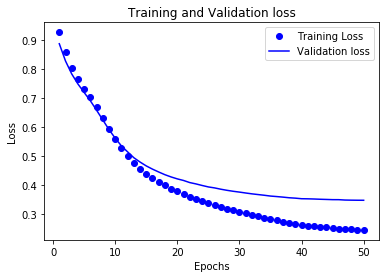

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

acc= history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) +1)

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label= 'Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

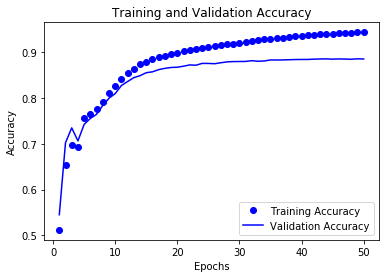

In [15]:
acc_values = history.history['acc']
val_acc_values = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label= 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Results

In [16]:
results = model.evaluate(X_test, test_labels)
results

25000/25000 [==============================] - 2s 76us/sample - loss: 0.3609 - acc: 0.8766


[0.3609348780250549, 0.8766]